In [2]:
%load_ext autoreload
%autoreload 2
import emcee
import numpy as np
import sys
sys.path.append('/data1/yujiehe/anisotropy-flamingo')
import tools.constants as const
import tools.clusterfit as cf
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306, Ob0=0.0486)

C = 299792.458                  # the speed of light in km/s


def log_likelihood(theta, X, Y, z_obs, phi_lc, theta_lc, yname, xname):
    """
    X, Y, z_obs, phi_lc, theta_lc, are from the data
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
       return -np.inf 
    
    ubf, vlon, vlat, logA, B, sigma, = theta

    # Set the scaling relation to know the pivot point
    scaling_relation = f'{yname}-{xname}'

    # Calculate the redshift
    angle = cf.angular_separation(phi_lc, theta_lc, vlon, vlat)
    
    # # Correct the bulk flow accordingly: z_bf = z_obs + ubf * (1 + z_bf) * np.cos(angle) / C
    # z_bf = (z_obs + ubf * np.cos(angle) / C) / (1 - ubf * np.cos(angle) / C) # Non-relativistic correction

    # The relativistic correction
    u_c_correct=((1+z_obs)**2-1)/((1+z_obs)**2+1) + (1+z_obs)*ubf*np.cos(angle)/C
    z_bf=np.sqrt((1+u_c_correct)/(1-u_c_correct))-1

    DL_zobs = cosmo.luminosity_distance(z_obs).value
    DL_zbf = cosmo.luminosity_distance(z_bf).value
    
    # Calculate the Luminosity distance
    DL_zobs = cosmo.luminosity_distance(z_obs).value
    DL_zbf = cosmo.luminosity_distance(z_bf).value
    Y_bf = Y*(DL_zbf)**2/(DL_zobs)**2
        
    # To our fit parameters
    logY_ = cf.logY_(Y_bf, z=z_bf, relation=scaling_relation)
    logX_ = cf.logX_(X, relation=scaling_relation)

    model = B * logX_ + logA
    # lnL = -0.5 * np.sum((logY_ - model) ** 2 / sigma**2 + np.log(2*np.pi*sigma**2))
    lnL = -0.5 * np.sum((logY_ - model) ** 2 / (sigma**2) + np.log(sigma**2)) # Kostas' implementation

    return lnL + lp

# set prior
def log_prior(theta):
    # A large flat prior for now
    ubf, vlon, vlat, logA, B, sigma = theta # 6 parameters

    # If in range, p(theta)=1, else p(theta)=0
    if 0.05<logA<1 and 0.5<B<3.5 and 0.05<sigma<1 \
        and 0<ubf<1000 and -180<vlon<180 and -90<vlat<90:
        return 0.0
    else:
        return -np.inf


In [3]:
import pandas as pd
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision_outlier_excision.csv')
data

,lc_id,redshift,theta_on_lc,phi_on_lc,M_fof_lc,x_lc,y_lc,z_lc,snap_num,MfofSOAP,...,Y5R500WithoutRecentAGNHeating,Vx,Vy,Vz,GalaxyID,TopLeafID,3DLcore/Ltot,ObservedRedshift,Flux,2DLcore/Ltot
0,12678101,0.049663,68.444418,-146.100556,3.221621e+14,-65.892905,-44.277266,200.964592,76,3.221569e+14,...,13.394281,-138.41480,146.285160,-258.814820,264729502,264729571,0.629913,0.048863,1.930583e-11,0.655002
1,13217952,0.031250,61.242576,66.517408,2.121565e+14,26.197568,60.300376,119.801093,76,2.122057e+14,...,8.353127,136.95007,85.050050,156.950070,758729120,758729192,0.563404,0.031943,3.424318e-11,0.619050
2,11897316,0.016130,-50.768598,-21.506782,9.199489e+13,41.950287,-16.530393,-55.223603,77,9.194666e+13,...,1.736042,-143.69714,-196.297180,-29.697144,735257909,735257982,0.587601,0.016076,1.415207e-11,0.580910
3,12785470,0.019369,28.752838,151.820271,1.019505e+14,-65.416111,35.046019,40.719139,77,1.019797e+14,...,2.198071,-126.92236,256.877560,1.177612,553518674,553518749,0.448886,0.020066,1.010312e-11,0.540358
4,6057316,0.077597,-74.324178,-132.555680,2.872746e+14,-61.330249,-66.799779,-323.142433,75,2.875223e+14,...,12.424476,168.31421,95.214230,99.214230,256178182,256178252,0.538358,0.077076,7.649637e-12,0.485846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,11804705,0.085544,22.449321,158.121013,5.532838e+14,-316.531368,127.109968,140.934807,75,5.530544e+14,...,77.584358,492.35680,242.556760,50.656740,795913407,795913476,0.020071,0.084388,2.813252e-11,0.060460
702,11861703,0.028225,-55.011456,-126.277785,7.538000e+13,-41.823558,-56.982167,-100.989675,76,7.531655e+13,...,2.511428,98.96692,-309.533080,-453.733030,261040288,261040362,0.020155,0.029877,7.749973e-12,0.057530
703,4646616,0.125712,-33.564085,-169.939991,8.079670e+14,-442.983802,-78.588470,-298.507096,74,8.081410e+14,...,140.383773,-671.88740,77.012570,-361.787350,690964560,690964632,0.002155,0.128495,6.101368e-12,0.047056
704,12882763,0.052263,43.009397,-35.045370,1.727982e+14,135.647971,-95.141897,154.556921,76,1.728982e+14,...,10.978919,-296.42468,159.875300,135.375300,583385361,583385430,0.011669,0.051729,5.409843e-12,0.042653


In [4]:
# Load data and set zmax
data  = data[:313]
yname = 'LX'
xname = 'T'
zmax  = 0.03

# Load data
z_obs    = data['ObservedRedshift'].values
X        = data[cf.COLUMNS[xname]].values
Y        = data[cf.COLUMNS[yname]].values
phi_lc   = data['phi_on_lc'].values
theta_lc = data['theta_on_lc'].values

# Select data below some redshift
zmask    = z_obs < zmax
z_obs    = z_obs[zmask]
X        = X[zmask]
Y        = Y[zmask]
phi_lc   = phi_lc[zmask]
theta_lc = theta_lc[zmask]

print(np.sum(zmask)) # Number of clusters left

29


### Scipy differential evolution
Update: it doesn't converge

In [5]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0, 0, 0, 1, 1, 0.1]) # initial guess
bounds = [(0, 1000), (-180, 180), (-90, 90), (0.1, 1), (0.5, 3.5), (0.05, 1)]

soln = differential_evolution(nll, args=(X, Y, z_obs, phi_lc, theta_lc, yname, xname), 
                bounds=bounds, popsize=10, strategy='rand1bin')
print(soln.x)

[ 9.26423647e+02 -1.72305318e+02  2.11520366e+00  1.51897453e-01
  2.77822817e+00  1.09562396e-01]


/data1/yujiehe/conda-env/halo/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


### MCMC with EMCEE

In [6]:
pos0 = soln.x + 1e-4 * np.random.randn(32, 6)
nwalkers, ndim = pos0.shape

# Create a sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(X, Y, z_obs, phi_lc, theta_lc, yname, xname))

# Run
sampler.run_mcmc(pos0, 15000, progress=True)

100%|██████████| 15000/15000 [05:41<00:00, 43.98it/s]


State([[ 1.84570650e+02 -1.56182394e+02 -6.89321999e+01  1.83242288e-01
   2.71113270e+00  1.24371776e-01]
 [ 9.35251750e+02  9.63005902e+01 -1.60996849e+01  1.04165925e-01
   2.46707608e+00  9.63065500e-02]
 [ 1.85226784e+02 -1.60521631e+02  2.50051583e+01  1.04290541e-01
   2.73959225e+00  1.75587463e-01]
 [ 3.47357540e+02  6.63795052e+01  2.46847890e+01  1.64362187e-01
   2.74689513e+00  1.10624498e-01]
 [ 3.80092375e+02 -1.65083351e+02  1.30916679e+01  1.57261090e-01
   2.74317591e+00  1.27146070e-01]
 [ 3.18052429e+02  1.89621307e+01 -2.40748587e+01  1.63231215e-01
   2.84567576e+00  1.17627146e-01]
 [ 2.10112509e+02  1.05837425e+02 -1.71910532e+01  1.92789691e-01
   2.77726055e+00  1.56295489e-01]
 [ 3.02743159e+02  9.57652098e+01 -4.49714286e+01  2.19254654e-01
   2.73908621e+00  1.22826155e-01]
 [ 6.47999625e+02  9.31338505e+01  3.63203009e+01  1.16933081e-01
   2.51807251e+00  1.11118293e-01]
 [ 5.87429770e+02 -1.19147006e+02 -3.45901389e+01  9.72534971e-02
   2.63949729e+00  

In [8]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: [631.31621591 640.77847828 296.69772096 249.38205754 347.75164143
 446.34084039]

In [9]:
flat_samples = sampler.get_chain(discard=1000, thin=60, flat=True)
print(flat_samples.shape)

(7456, 6)


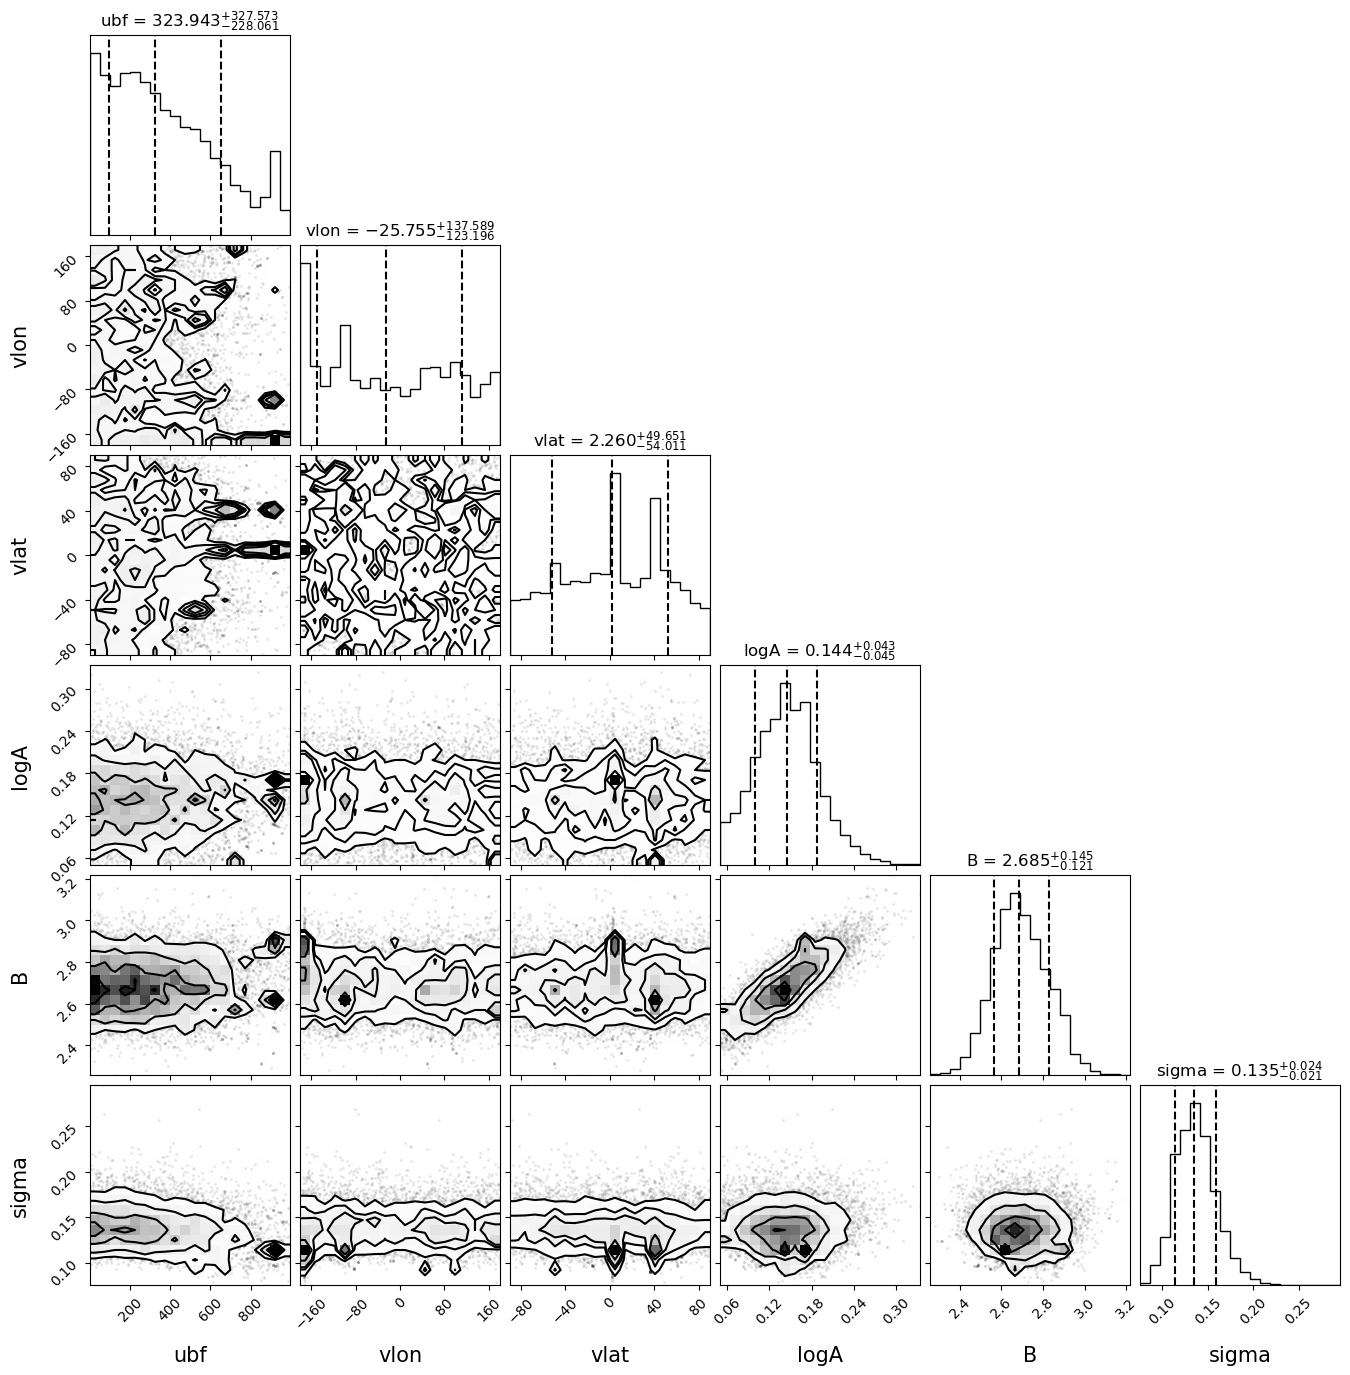

In [10]:
import corner

fig = corner.corner(
    flat_samples, 
    labels=['ubf', 'vlon', 'vlat', 'logA', 'B', 'sigma'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, 
    title_fmt='.3f',
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 15}
)

In [1]:
maxidx = np.where(sampler.get_log_prob() == np.max(sampler.get_log_prob()))
sampler.get_chain()[maxidx][0]

NameError: name 'np' is not defined